# Import module

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas_datareader as web
import talib
import seaborn as sns
import gym
from gym import spaces
from gym.utils import seeding
import enum
import pyfolio as pf
import matplotlib.pyplot as plt
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import random
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

C:\Users\User\anaconda3\envs\MyDjango\lib\site-packages\pyfolio\pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


# Stock Data

Stock name: ETC-USD
Start: 2021-01-22 17:30:00+00:00, End: 2021-03-22 15:00:00+00:00
Training data: 1367 
Tsesting data: 1368 


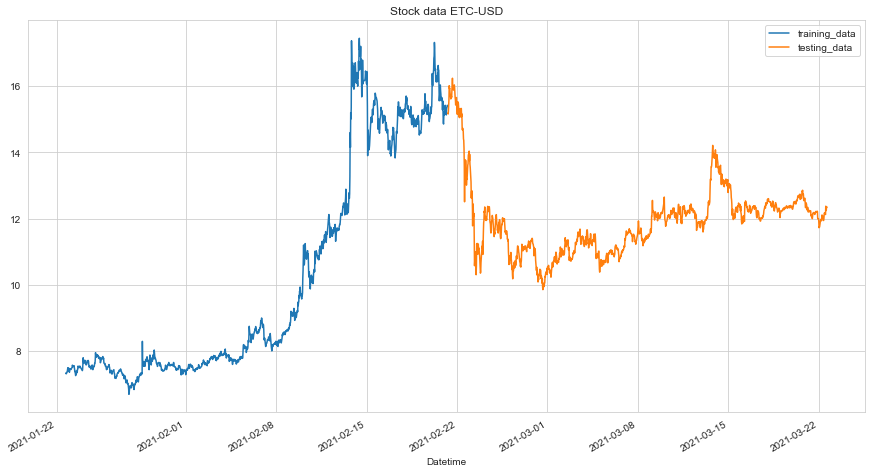

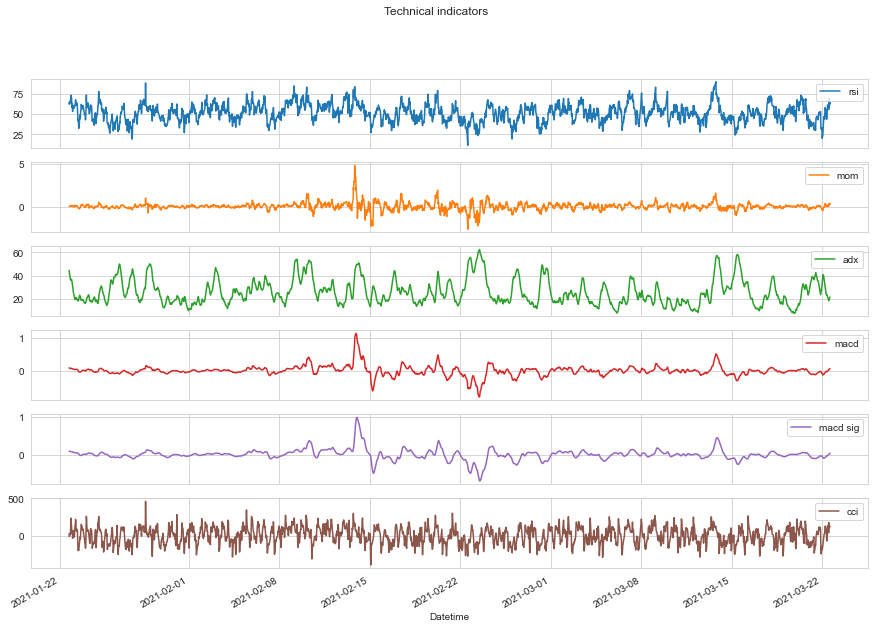

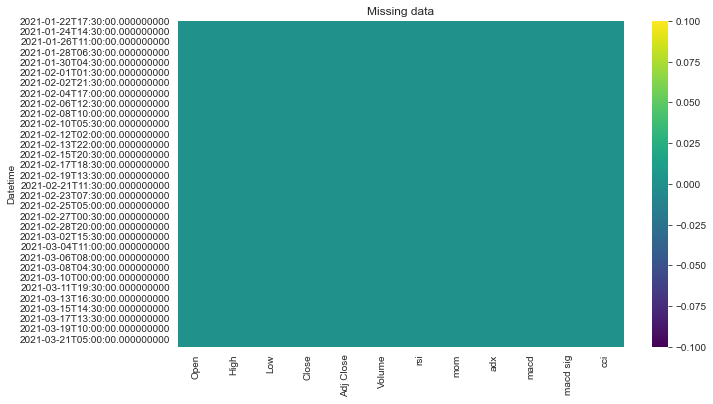

,Open,High,Low,Close,Adj Close,Volume,rsi,mom,adx,macd,macd sig,cci
Datetime,,,,,,,,,,,,
2021-01-22 17:30:00+00:00,7.368124,7.368124,7.322860,7.330975,7.330975,3006464.0,64.397732,0.066247,44.755911,0.100661,0.102679,35.128620
2021-01-22 18:00:00+00:00,7.331477,7.334888,7.301473,7.310931,7.310931,4802304.0,62.140626,0.062866,42.652749,0.092770,0.100697,-3.963472
2021-01-22 18:30:00+00:00,7.311155,7.346560,7.311155,7.346560,7.346560,10557952.0,64.521086,0.039610,40.872870,0.088371,0.098232,12.181161
2021-01-22 19:00:00+00:00,7.346368,7.360384,7.331641,7.337577,7.337577,8144896.0,63.438135,0.041542,39.427008,0.083202,0.095226,15.474028
2021-01-22 19:30:00+00:00,7.336986,7.373943,7.334821,7.370145,7.370145,7290496.0,65.686982,-0.005034,38.287700,0.080801,0.092341,37.446124


In [2]:
stock_name = 'etc-usd'.upper()
industry = 'Cryptocurrentcy'

stock_data = pd.read_csv('data/'+stock_name+'.csv', parse_dates=True)
stock_data['Datetime'] = pd.to_datetime(stock_data['Datetime'])
stock_data.set_index('Datetime', inplace=True)

n_train = len(stock_data)//2
train_data = stock_data.iloc[:n_train]
test_data = stock_data.iloc[n_train:]



print(f'Stock name: {stock_name}')
print(f'Start: {stock_data.index[0]}, End: {stock_data.index[-1]}')
print(f'Training data: {len(train_data)} ')
print(f'Tsesting data: {len(test_data)} ')

sns.set_style('whitegrid')
train_data['Adj Close'].plot(label='training_data', figsize=(15,8));
test_data['Adj Close'].plot(label='testing_data');
plt.title('Stock data '+ stock_name)
plt.legend();
plt.show()

stock_data[['rsi', 'mom', 'adx', 'macd', 'macd sig', 'cci']].plot(subplots=True, figsize=(15,10), title='Technical indicators');
plt.show()


plt.figure(figsize=(10,6))
sns.heatmap(stock_data.isnull(), cmap='viridis');
plt.title('Missing data');
plt.show()

stock_data.head()

# Agent

In [3]:
    
    
class DQNAgent:
    '''Agent'''

    def __init__(self,
                 input_sz,
                 action_sz,
                 discount_factor=0.9,
                 epsilon=1,
                 epsilon_min=0.001,
                 epsilon_decay=0.995,
                 batch_size=128,
                 lr=0.001,
                 ticker = '',
                 capacity=10000,
                 layers=[100, 100, 100]):
        
        
        # network for predict q values (input = state vector, output = q values dim action size)
        self.network = self.build_model_nn(input_sz, action_sz, layers=layers)
        self.target_network = self.build_model_nn(input_sz, action_sz, layers=layers)
        self.update_target_network()
        
        self.discount_factor = discount_factor  # discount factor (gamma)
        self.reward_window = []
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr) #Adam optimizer learning rate default = 0.001
        self.last_state = torch.Tensor(input_sz).unsqueeze(0)  # shape [1, 5]
        self.last_action = 0
        self.last_reward = 0

        # epsilon greedy selection
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.save_epsilon = []

        self.batch_size = batch_size #batch size
        self.action_sz = action_sz
        self.criterion = nn.MSELoss() #Mean squared error loss
        self.losses = []
        self.stock_name = ticker
        
        #experience replay
        self.capacity = capacity
        self.memory = []
        
        
    def seed(self, seeding=101):
        return torch.manual_seed(seeding)
        
        
    def build_model_nn(self, input_sz, action_sz, layers):
        
        class NeuralNetwork(nn.Module):
            '''
            Network for predict action trading
            '''

            def __init__(self, input_sz, action_sz, layers=[100, 100, 100]):
                super().__init__()
                self.input_sz = input_sz
                self.action_sz = action_sz
                self.fc1 = nn.Linear(input_sz, layers[0])
                self.fc2 = nn.Linear(layers[0], layers[1])
                self.fc3 = nn.Linear(layers[1], layers[2])
                self.out = nn.Linear(layers[2], action_sz)

            def forward(self, state):
                x = F.relu(self.fc1(state))
                x = F.relu(self.fc2(x))
                x = F.relu(self.fc3(x))
                q_values = self.out(x)
                return q_values
        
        self.seed()

        model = NeuralNetwork(input_sz, action_sz, layers=layers)
        
        return model
        
        
        
    def update_target_network(self):
        self.target_network.load_state_dict(self.network.state_dict())
        self.target_network.eval()


    def get_action(self, state):
        '''
        Epsilon-greedy selection
        '''
        
        if np.random.rand() <= self.epsilon:
            # if random samples from a uniform distribution over [0, 1) less than epsilon
            return np.random.choice(self.action_sz) # return random choice of action space
        
        # else return action maximum q values from network
        q_values = self.network(state.clone().detach())
        q_values_prob = F.softmax(q_values * 10, dim=0)
        action = q_values_prob.multinomial(num_samples=1)
        return action.data[0, 0]
    

    def train(self, batch_state, batch_next_state, batch_action, batch_reward):
        outputs = self.network(batch_state).gather(1, batch_action.unsqueeze(1)).squeeze(1)
        
        next_outputs = self.target_network(batch_next_state).detach().max(1)[0]
        target =  batch_reward + self.discount_factor * next_outputs # reward + gamma*Q(s',a')
        
        loss = F.smooth_l1_loss(outputs, target) # (1/n) * sum(zi)
        self.losses.append(loss.item())
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        

    def update(self, reward, new_state):
        new_state = torch.tensor(new_state[0]).float().unsqueeze(0) #state vector
        
        # push (last state, new state, last action, last reward into memory)
        self.push((self.last_state,
                  new_state,
                  torch.LongTensor([int(self.last_action)]),
                  torch.Tensor([self.last_reward])))
        # get action
        action = self.get_action(new_state)

        if len(self.memory) > self.batch_size:
            # sample batch event from memory (experience replay)
            batch_state, batch_next_state, batch_action, batch_reward = self.sample(self.batch_size)
            # learn
            self.train(batch_state, batch_next_state, batch_action, batch_reward)

        # decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        self.save_epsilon.append(self.epsilon)
        
        self.update_target_network()

        self.last_action = action
        self.last_state = new_state
        self.last_reward = reward
        self.reward_window.append(reward)
        # add reward to window reward
        if len(self.reward_window) > self.batch_size:
            del self.reward_window[0]
        return action
    
    
    def push(self, event):
        self.memory.append(event)
        if len(self.memory) > self.capacity:
            del self.memory[0]
            

    def sample(self, batch_size):
        '''
        Sample event from memory (len = batch size)
        '''
        
        # [batch_state, batch_next_state, batch_action, batch_reward]
        samples = zip(*random.sample(self.memory, batch_size))
        return map(lambda x: Variable(torch.cat(x, 0)), samples)
    

    def score(self):
        return sum(self.reward_window) / (len(self.reward_window) + 1.)

    def save(self):
        torch.save({'state_dict': self.network.state_dict(),
                    'optimizer': self.optimizer.state_dict(),
                    }, 'state_dict/' + self.stock_name + '.pth')
        print('=> Saved!!!...')

    def load(self):
        if os.path.isfile('state_dict/' + self.stock_name + '.pth'):
            print("loading state dict form " + self.stock_name)
            checkpoint = torch.load('state_dict/' + self.stock_name + '.pth')
            self.network.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.network.eval()
            print('Completed!')
        else:
            print("no parameters found...")    


# Environment

In [4]:
# environment

class Actions(enum.Enum):
    Sell = 0
    Buy = 1
    Hold = 2


class Positions(enum.Enum):
    Short = 0
    Long = 1

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long
    


class SingleStockEnv(gym.Env):
    '''
    Single Stock for trading

    '''
    
    metadata = {'render.modes': ['human']}

    def __init__(self, data, capital, trade_fee_bid_percent = 0.0025, trade_fee_ask_percent = 0.0025):
        
        self.trade_fee_bid_percent = trade_fee_bid_percent/100  # percent
        self.trade_fee_ask_percent = trade_fee_ask_percent/100  # percent
        self.stock_price_history = data
        self.n_step = self.stock_price_history.shape[0]
        self.capital = capital
        self.stock_owned = None
        self.stock_price = None
        self.cash_in_hand = None
        self.state_dim = 9  # [stock price, stock_owned, cash_in_hand, rsi, mom, adx, macd, macd_sig, cci]
        self.save_position = []
        self.save_port_val = []
        self.save_cash = []
        self.total_reward = None
        self.stock_value = []
        self.sell_buy = None
        self.save_stock_price = []
        
        # space
        self.action_space = spaces.Discrete(len(Actions)) # 0, 1, 2
        
        # episode
        self.start_tick = 0
        self.end_tick = self.n_step - 1
        self.current_tick = None
        self.done = None
        self._position = None
        self._position_history = None
        self.save_reward = []
        self.rsi = None
        self.mom = None
        self.adx = None
        self.macd = None
        self.masc_sig = None
        self.cci = None
        
        self.reset()
        

        
        
    def reset(self):
        self.done = False
        self.current_tick = self.start_tick = 0
        self.stock_owned = 0.
        self.stock_price = self.stock_price_history['Adj Close'][self.current_tick]
        self.cash_in_hand = self.capital
        self.save_position = [0]
        self.save_port_val = [self.capital]
        self.save_cash = [self.capital]
        self.total_reward = [0]
        self.stock_value = [0]
        self.sell_buy = ['hold']
        self._position = Positions.Short
        self._position_history = [self._position]
        self.save_stock_price = [self.stock_price]
        self.rsi = self.stock_price_history['rsi'][self.current_tick]
        self.mom = self.stock_price_history['mom'][self.current_tick]
        self.adx = self.stock_price_history['adx'][self.current_tick]
        self.macd = self.stock_price_history['macd'][self.current_tick]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_tick]
        self.cci = self.stock_price_history['cci'][self.current_tick]
        return self.state_vector()
        

    def state_vector(self):
        vector = np.empty(self.state_dim)
        vector[0] = self.stock_price
        vector[1] = self.stock_owned
        vector[2] = self.cash_in_hand
        vector[3] = self.rsi
        vector[4] = self.mom
        vector[5] = self.adx
        vector[6] = self.macd
        vector[7] = self.masc_sig
        vector[8] = self.cci
        return vector


    def port_val(self):
        return (self.stock_owned * self.stock_price) + self.cash_in_hand
    

    def trade(self, action):
            
        if (action == Actions.Sell.value and self._position == Positions.Long):
            # sell
            self.cash_in_hand += ((self.stock_owned * self.stock_price) * (1 - self.trade_fee_bid_percent))
            self.stock_owned -= self.stock_owned
            self.sell_buy.append('sell')

        elif (action == Actions.Buy.value and self._position == Positions.Short):            
            # buy
            self.stock_owned += ((self.cash_in_hand * (1 - self.trade_fee_ask_percent)) / self.stock_price)
            self.cash_in_hand -= ((self.cash_in_hand / self.stock_price) * self.stock_price)
            self.sell_buy.append('buy')

            
    def step(self, action):

        prev_port_val = self.port_val()
        self.current_tick += 1
        
        if self.current_tick == self.end_tick:
            self.done = True
            

        
        self.stock_price = self.stock_price_history['Adj Close'][self.current_tick]
        self.rsi = self.stock_price_history['rsi'][self.current_tick]
        self.mom = self.stock_price_history['mom'][self.current_tick]
        self.adx = self.stock_price_history['adx'][self.current_tick]
        self.macd = self.stock_price_history['macd'][self.current_tick]
        self.masc_sig = self.stock_price_history['macd sig'][self.current_tick]
        self.cci = self.stock_price_history['cci'][self.current_tick]
        
        trade = False
        if ((action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)):
            trade = True
            
        if trade:
            self.trade(action)
            self._position = self._position.opposite()
            
        else:
            self.sell_buy.append('hold')
            
        self._position_history.append(self._position)
            
        current_port_val = self.port_val()
        step_reward = current_port_val - prev_port_val
        self.total_reward.append(step_reward)
        self.save_reward.append(step_reward)
        self.save_cash.append(self.cash_in_hand)
        self.save_port_val.append(self.port_val())
        self.save_position.append(self.stock_owned)
        self.stock_value.append(self.stock_owned * self.stock_price)
        self.save_stock_price.append(self.stock_price)
        
        
        info = {'stock_price': self.save_stock_price,
                'portfolio_value': self.save_port_val,
                'current_val': self.total_reward,
                'stock_owned': self.save_position,
                'cash_in_hand': self.save_cash,
                'stock_value': self.stock_value,
                'sell_buy': self.sell_buy,
                }
        return self.state_vector(), step_reward, self.done, info
    
    
    def get_scaler(self):
        states = []
        self.reset()
        for i in range(self.n_step):
            action = self.action_space.sample()
            state, reward, done, info = self.step(action)
            states.append(state)
            if done:
                break
        scaler = StandardScaler()
        scaler.fit(states)
        return scaler

        

# Config

In [5]:
num_episodes = 500
capital = 1000
train_env = SingleStockEnv(data=train_data,
                           capital=capital,
                           trade_fee_bid_percent = 0.0025,
                           trade_fee_ask_percent = 0.0025)
state_size = train_env.state_dim
nb_action = train_env.action_space.n
agent = DQNAgent(input_sz=state_size,
                 action_sz=nb_action,
                 discount_factor=0.9,
                 ticker=stock_name,
                 batch_size=128,
                 lr=0.001,
                 capacity=10000,
                 layers=[100, 100, 100])
scaler = train_env.get_scaler()

# Training

Training Model


  0%|          | 0/500 [00:00<?, ?it/s]

Episode:    1/500
Begin portfolio value:  1000.00
End portfolio value:    1431.93
Since: 1367 days
Return 43.19 %
Epsilon: 0.00106
Sell: 233, Buy: 234
Cumulative Reward:   431.93
Mean Squared Error Loss:   7.0495


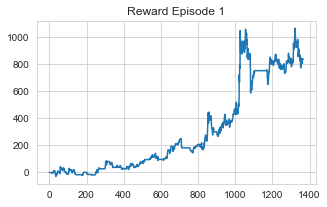


Episode:   25/500
Begin portfolio value:  1000.00
End portfolio value:    1228.63
Since: 1367 days
Return 22.86 %
Epsilon: 0.00100
Sell: 230, Buy: 231
Cumulative Reward:   228.63
Mean Squared Error Loss:   6.0183


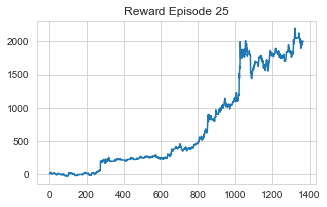


Episode:   50/500
Begin portfolio value:  1000.00
End portfolio value:    1508.23
Since: 1367 days
Return 50.82 %
Epsilon: 0.00100
Sell: 209, Buy: 209
Cumulative Reward:   508.23
Mean Squared Error Loss:   4.9978


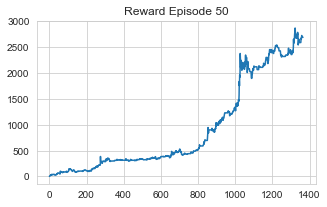


Episode:   75/500
Begin portfolio value:  1000.00
End portfolio value:     916.64
Since: 1367 days
Return -8.34 %
Epsilon: 0.00100
Sell: 233, Buy: 234
Cumulative Reward:   -83.36
Mean Squared Error Loss:   5.3843


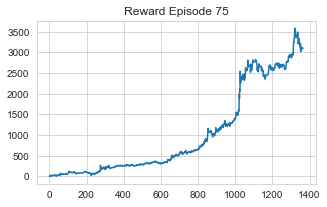


Episode:  100/500
Begin portfolio value:  1000.00
End portfolio value:    1517.85
Since: 1367 days
Return 51.79 %
Epsilon: 0.00100
Sell: 231, Buy: 232
Cumulative Reward:   517.85
Mean Squared Error Loss:   5.2784


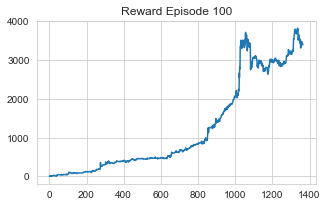


Episode:  125/500
Begin portfolio value:  1000.00
End portfolio value:    1463.57
Since: 1367 days
Return 46.36 %
Epsilon: 0.00100
Sell: 217, Buy: 217
Cumulative Reward:   463.57
Mean Squared Error Loss:   3.4539


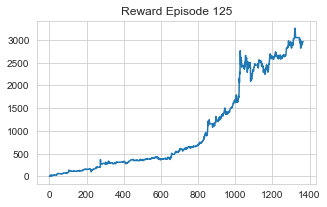


Episode:  150/500
Begin portfolio value:  1000.00
End portfolio value:    2556.97
Since: 1367 days
Return 155.70 %
Epsilon: 0.00100
Sell: 217, Buy: 217
Cumulative Reward:  1556.97
Mean Squared Error Loss:   3.4492


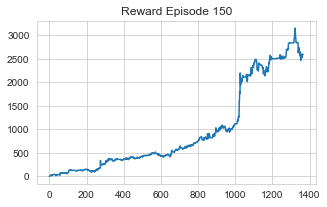


Episode:  175/500
Begin portfolio value:  1000.00
End portfolio value:    1724.91
Since: 1367 days
Return 72.49 %
Epsilon: 0.00100
Sell: 227, Buy: 228
Cumulative Reward:   724.91
Mean Squared Error Loss:   3.2917


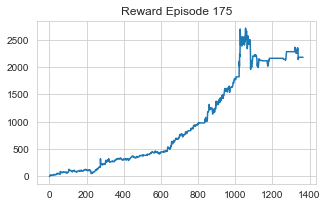


Episode:  200/500
Begin portfolio value:  1000.00
End portfolio value:    1222.03
Since: 1367 days
Return 22.20 %
Epsilon: 0.00100
Sell: 224, Buy: 224
Cumulative Reward:   222.03
Mean Squared Error Loss:   3.9664


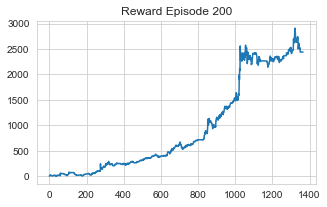


Episode:  225/500
Begin portfolio value:  1000.00
End portfolio value:    1159.29
Since: 1367 days
Return 15.93 %
Epsilon: 0.00100
Sell: 219, Buy: 219
Cumulative Reward:   159.29
Mean Squared Error Loss:   3.7937


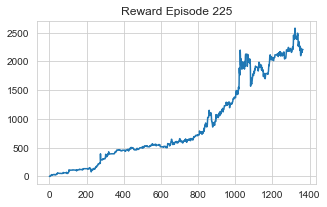


Episode:  250/500
Begin portfolio value:  1000.00
End portfolio value:     977.69
Since: 1367 days
Return -2.23 %
Epsilon: 0.00100
Sell: 227, Buy: 227
Cumulative Reward:   -22.31
Mean Squared Error Loss:   4.0169


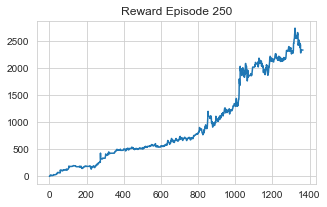


Episode:  275/500
Begin portfolio value:  1000.00
End portfolio value:    1052.89
Since: 1367 days
Return 5.29 %
Epsilon: 0.00100
Sell: 220, Buy: 221
Cumulative Reward:    52.89
Mean Squared Error Loss:   3.8045


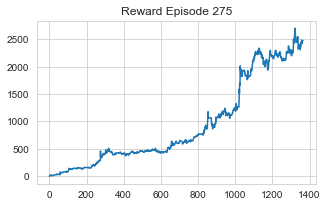


Episode:  300/500
Begin portfolio value:  1000.00
End portfolio value:    1159.10
Since: 1367 days
Return 15.91 %
Epsilon: 0.00100
Sell: 244, Buy: 244
Cumulative Reward:   159.10
Mean Squared Error Loss:   4.0810


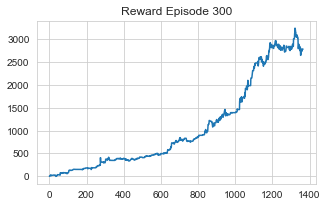


Episode:  325/500
Begin portfolio value:  1000.00
End portfolio value:    1244.29
Since: 1367 days
Return 24.43 %
Epsilon: 0.00100
Sell: 235, Buy: 235
Cumulative Reward:   244.29
Mean Squared Error Loss:   3.8943


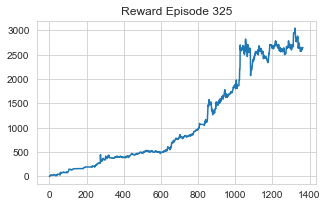


Episode:  350/500
Begin portfolio value:  1000.00
End portfolio value:    2141.13
Since: 1367 days
Return 114.11 %
Epsilon: 0.00100
Sell: 230, Buy: 230
Cumulative Reward:  1141.13
Mean Squared Error Loss:   4.0666


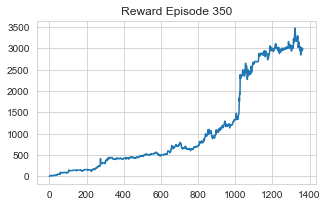


Episode:  375/500
Begin portfolio value:  1000.00
End portfolio value:    1818.04
Since: 1367 days
Return 81.80 %
Epsilon: 0.00100
Sell: 223, Buy: 223
Cumulative Reward:   818.04
Mean Squared Error Loss:   4.2200


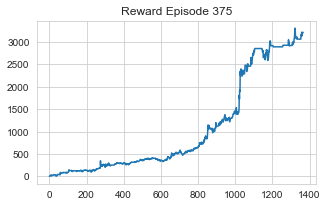


Episode:  400/500
Begin portfolio value:  1000.00
End portfolio value:    1396.06
Since: 1367 days
Return 39.61 %
Epsilon: 0.00100
Sell: 229, Buy: 230
Cumulative Reward:   396.06
Mean Squared Error Loss:   3.6502


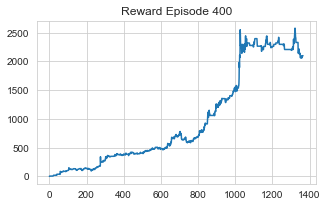


Episode:  425/500
Begin portfolio value:  1000.00
End portfolio value:    1037.59
Since: 1367 days
Return 3.76 %
Epsilon: 0.00100
Sell: 235, Buy: 235
Cumulative Reward:    37.59
Mean Squared Error Loss:   6.9933


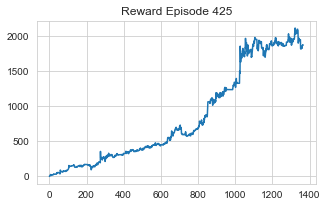


Episode:  450/500
Begin portfolio value:  1000.00
End portfolio value:    1723.92
Since: 1367 days
Return 72.39 %
Epsilon: 0.00100
Sell: 218, Buy: 219
Cumulative Reward:   723.92
Mean Squared Error Loss:   3.3913


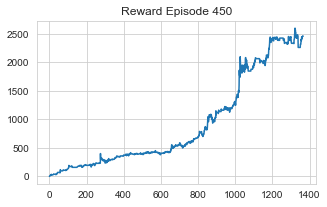


Episode:  475/500
Begin portfolio value:  1000.00
End portfolio value:    1423.98
Since: 1367 days
Return 42.40 %
Epsilon: 0.00100
Sell: 234, Buy: 234
Cumulative Reward:   423.98
Mean Squared Error Loss:   3.8889


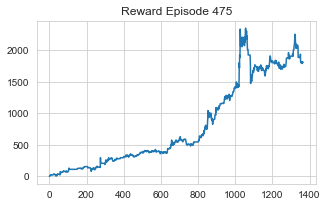


Episode:  500/500
Begin portfolio value:  1000.00
End portfolio value:    1909.55
Since: 1367 days
Return 90.95 %
Epsilon: 0.00100
Sell: 212, Buy: 212
Cumulative Reward:   909.55
Mean Squared Error Loss:   4.1675


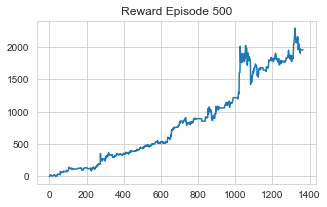


=> Saved!!!...
average reward: 1567.26, min: 756.41, max: 4408.70


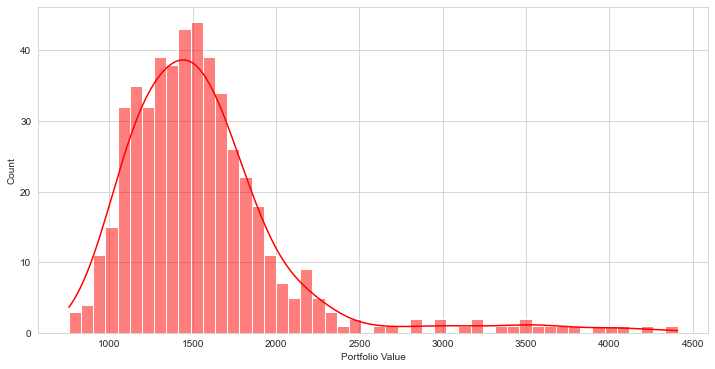

In [6]:
print('Training Model')
portfolio_value = []
total_reward = []
for e in tqdm(range(num_episodes)):
    step_reward = 0
    last_state = train_env.reset()
    last_reward = 0
    done = False
    scores = []
    while not done:
        last_state = scaler.transform([last_state])
        action = agent.update(last_reward, last_state)
        scores.append(agent.score())
        last_state, last_reward, done, info = train_env.step(action) 
        step_reward += last_reward
    
    total_reward.append(step_reward)
    
    if (e+1) % (num_episodes/20) == 0 or (e+1 == 1):     
        print(f"Episode: {e + 1:4}/{num_episodes}")
        print(f"Begin portfolio value: {capital:8.2f}")
        print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
        print(f'Since: {len(train_data)} days')
        print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
        print(f"Epsilon: {agent.save_epsilon[-1]:2.5f}")
        print(f"Sell: {train_env.sell_buy.count('sell')}, Buy: {train_env.sell_buy.count('buy')}")
        print(f'Cumulative Reward: {total_reward[-1]:8.2f}')
        print(f"Mean Squared Error Loss: {agent.losses[-1]:8.4f}")
        
        
        
        env = SingleStockEnv(train_data,
                             capital,                           
                             trade_fee_bid_percent = 0.0025,
                             trade_fee_ask_percent = 0.0025)
        last_state = env.reset()
        history_reward = []
        _done = False
        while not _done:
            last_state = scaler.transform([last_state])
            last_state = torch.Tensor(last_state[0]).float().unsqueeze(0)
            with torch.no_grad():
                action = agent.network(last_state).argmax().item()
            last_state, last_reward, _done, info = env.step(action)
            history_reward.append(last_reward)
        
        pd.Series(history_reward).cumsum().plot(figsize=(5,3))
        plt.title('Reward Episode '+ str(e+1))
        plt.show()
        

        print('=======================================================================')
        print()
    
    portfolio_value.append(info['portfolio_value'][-1]) 

# total_reward = train_env.save_reward

with open(f'scaler/{stock_name}.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
agent.save()
losses = agent.losses

print(f'average reward: {np.mean(portfolio_value):.2f}, min: {np.min(portfolio_value):.2f}, max: {np.max(portfolio_value):.2f}')
plt.figure(figsize=(12,6))
sns.histplot(portfolio_value, bins=50, color='r', kde=True);
plt.xlabel('Portfolio Value');
plt.ylabel('Count');

# Loss

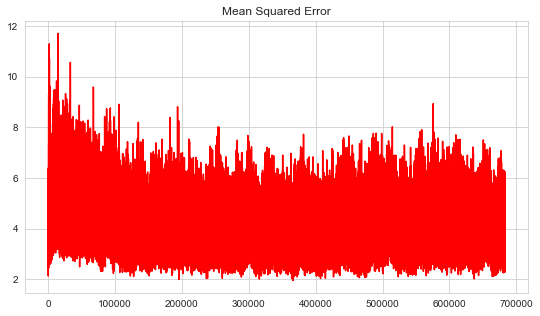

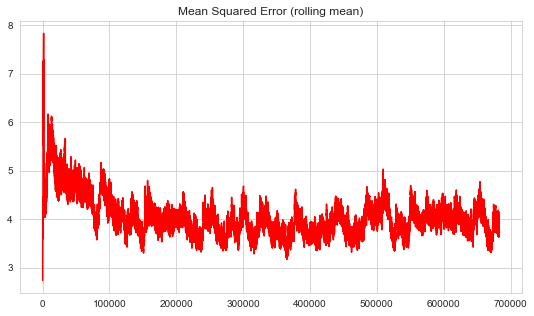

In [7]:
pd.Series(losses).plot(figsize=(9,5), c='r');
plt.title('Mean Squared Error');
plt.show()
pd.Series(losses).rolling(100).mean().plot(figsize=(9,5), c='r');
plt.title('Mean Squared Error (rolling mean)');

# Score

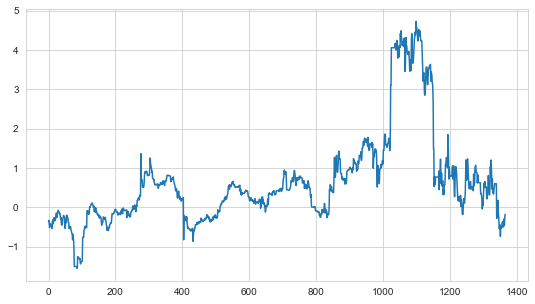

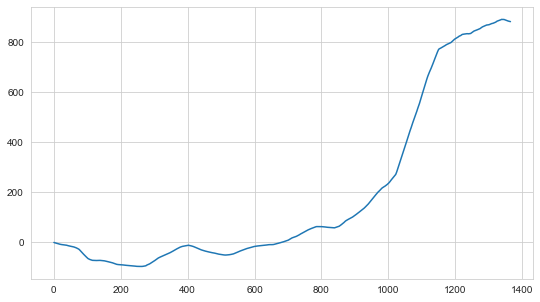

In [8]:
pd.Series(scores).plot(figsize=(9,5));
plt.show()
pd.Series(scores).cumsum().plot(figsize=(9,5));

# Reward

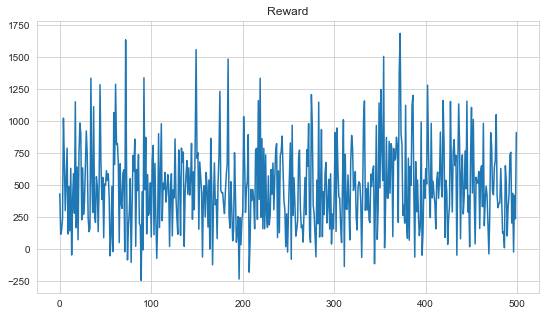

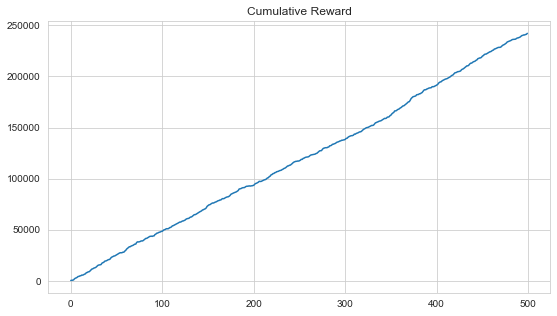

In [9]:
plt.figure(figsize=(9,5));
plt.plot(total_reward);
plt.title('Reward');
plt.show()
pd.Series(total_reward).cumsum().plot(figsize=(9,5));
plt.title('Cumulative Reward');

# Epsilon

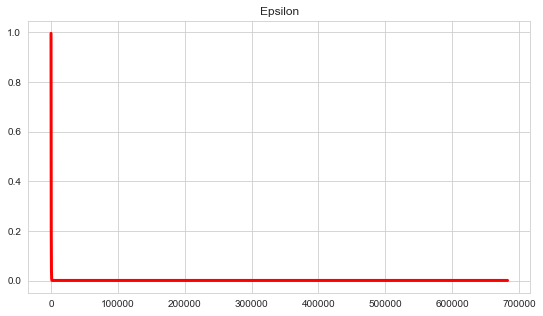

In [10]:
plt.figure(figsize=(9,5))
plt.plot(agent.save_epsilon, lw=3, c='r');plt.title('Epsilon');

# Validation

loading state dict form ETC-USD
Completed!
Testing Model



Start: 2021-02-21 07:00:00+00:00  End: 2021-03-22 15:00:00+00:00
Since: 1368 days
Begin portfolio value:  1000.00
End portfolio value:    2958.65
Return 195.87 %
Sell: 109 times, Buy: 109 times


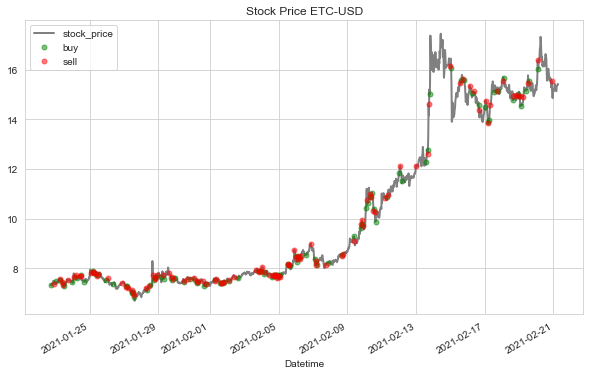

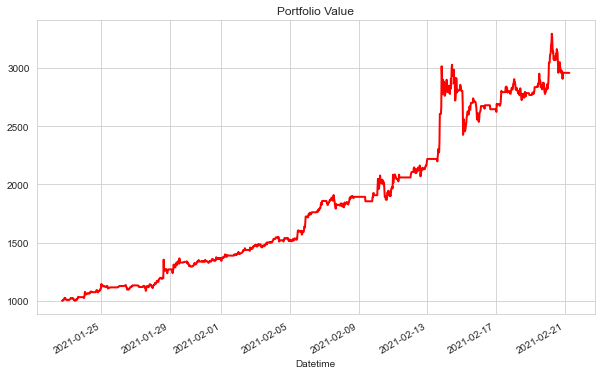

In [5]:
#validation 
capital = 1000
val_env = SingleStockEnv(train_data,
                         capital,
                         trade_fee_bid_percent = 0.0025,
                         trade_fee_ask_percent = 0.0025)
state_size = val_env.state_dim
nb_action = val_env.action_space.n
agent = DQNAgent(state_size, nb_action, 0.9, ticker=stock_name, layers=[100,100,100])
with open(f'scaler/{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)


last_state = val_env.reset()
last_reward = 0
done = False
agent.load()

while not done:
    last_state = scaler.transform([last_state])
    last_state = torch.Tensor(last_state[0]).float().unsqueeze(0)
    with torch.no_grad():
        action = agent.network(last_state).argmax().item()
    last_state, last_reward, done, info = val_env.step(action)


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {val_env.sell_buy.count('sell')} times, Buy: {val_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = train_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw='2', alpha=1);
result['marker_buy'].plot(style='o', ms=5, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=5, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()

result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()

# Testing

loading state dict form ETC-USD
Completed!
Testing Model



Start: 2021-02-21 07:00:00+00:00  End: 2021-03-22 15:00:00+00:00
Since: 1368 days
Begin portfolio value:  1000.00
End portfolio value:     859.54
Return -14.05 %
Sell: 127 times, Buy: 128 times


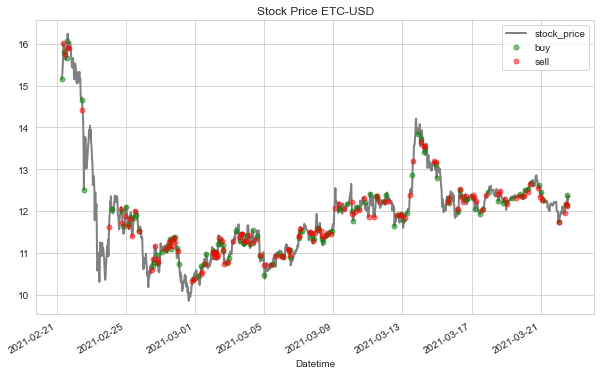

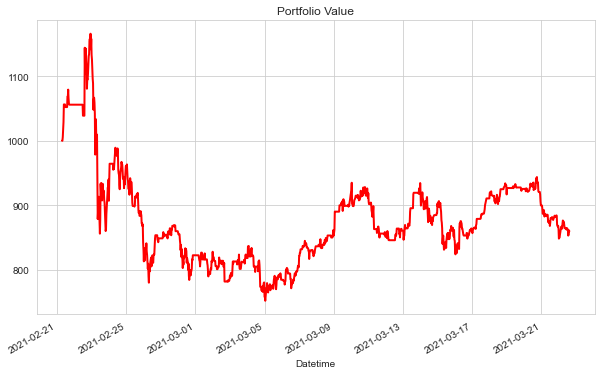

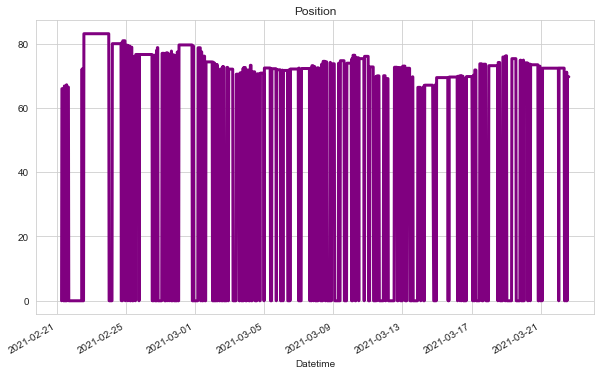

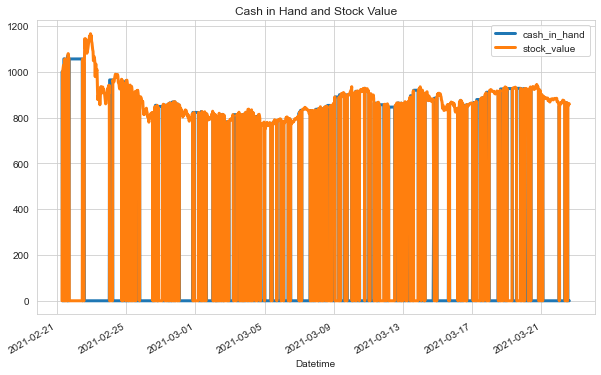

In [6]:
test_env = SingleStockEnv(test_data, 
                          capital,
                          trade_fee_bid_percent = 0.0025,
                          trade_fee_ask_percent = 0.0025)
state_size = test_env.state_dim
nb_action = test_env.action_space.n
agent = DQNAgent(state_size, nb_action, 0.9, ticker=stock_name, layers=[100,100,100])
with open(f'scaler/{stock_name}.pkl', 'rb') as f:
    scaler = pickle.load(f)


last_state = test_env.reset()
last_reward = 0
done = False
agent.load()

while not done:
    last_state = scaler.transform([last_state])
    last_state = torch.Tensor(last_state[0]).float().unsqueeze(0)
    with torch.no_grad():
        action = agent.network(last_state).argmax().item()
    last_state, last_reward, done, info = test_env.step(action)


print('Testing Model')
print('=======================================================================')
print('=======================================================================')
print()
print()
print()
print(f'Start: {test_data.index[0]}  End: {test_data.index[-1]}')
print(f'Since: {len(test_data)} days')
print(f"Begin portfolio value: {capital:8.2f}")
print(f"End portfolio value: {info['portfolio_value'][-1]:10.2f}")
print(f"Return {(info['portfolio_value'][-1] - capital) * 100/capital:.2f} %")
print(f"Sell: {test_env.sell_buy.count('sell')} times, Buy: {test_env.sell_buy.count('buy')} times")
print('=======================================================================')

result = pd.DataFrame(info)
result.index = test_data.index

def marker_buy(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'buy':
        return price
    else:
        return np.nan
    
def marker_sell(col):
    price = col[0] 
    sellbuy = col[1]
    
    if sellbuy == 'sell':
        return price
    else:
        return np.nan
    
result['marker_buy'] = result[['stock_price', 'sell_buy']].apply(marker_buy, axis=1);
result['marker_sell'] = result[['stock_price', 'sell_buy']].apply(marker_sell, axis=1);

result['stock_price'].plot(figsize=(10,6), c='grey', lw='2', alpha=1);
result['marker_buy'].plot(style='o', ms=5, label='buy', c='g', alpha=0.5);
result['marker_sell'].plot(style='o', ms=5, label='sell', c='r', alpha=0.5);
plt.title('Stock Price '+ stock_name)
plt.legend();
plt.show()

result['portfolio_value'].plot(figsize=(10,6), c='r', lw=2);
plt.title('Portfolio Value');
plt.show()

result['stock_owned'].plot(figsize=(10,6), c='purple', lw=3);
plt.title('Position')
plt.show()

result[['cash_in_hand', 'stock_value']].plot(figsize=(10,6), lw=3);
plt.title('Cash in Hand and Stock Value');
plt.show()

# Performance Measurement - KPIs

In [7]:
import numpy as np
import datetime as dt



def CAGR(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    n = len(df)/17520
    cagr = (df['cumulative_ret'][-1])**(1/n) - 1
    return cagr

def volatility(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    vol = df['daily_ret'].std() * np.sqrt(17520)
    return vol


def sharpe(DF, rf):
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr

def max_dd(DF):
    df = DF.copy()
    try:
        df['daily_ret'] = df['portfolio_value'].pct_change()
    except:
        df['daily_ret'] = df['Adj Close'].pct_change() 
    df['cumulative_ret'] = (1 + df['daily_ret']).cumprod()
    df['cum_roll_max'] = df['cumulative_ret'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cumulative_ret']
    df['drawdown_pct'] = df['drawdown']/df['cum_roll_max']
    max_dd = df['drawdown_pct'].max()
    return max_dd

def calmer(DF):
    df = DF.copy()
    clmr = CAGR(df)/max_dd(df)
    return clmr



print(f'Stock name: {stock_name}')
print(f'Start: {result.index[0]}  End: {result.index[-1]}')
print(f'Compound Annual Growth Rate: {CAGR(result)*100:.2f} %')
print(f'Volatility: {volatility(result):.4f}')
print(f'shape ratio: {sharpe(result, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(result)*-100:.2f} %')
print(f'Calmar ratio: {calmer(result):.4f}')
print('-----------------------------------------------------------')
# print('Comparing with Benchmark')
# print(f'Compound Annual Growth Rate (benchmark): {CAGR(bn)*100:.2f} %')
# print(f'Volatility (benchmark): {volatility(bn):.4f}')
# print(f'shape ratio: {sharpe(bn, 0.011):.4f}')
# print(f'Maximun drawdown: {max_dd(bn)*-100:.2f} %')
# print(f'Calmar ratio (benchmark): {calmer(bn):.4f}')
# print('-----------------------------------------------------------')
print('Comparing with Adj close')
print(f'Compound Annual Growth Rate (Adj close): {CAGR(test_data)*100:.2f} %')
print(f'Volatility (benchmark): {volatility(test_data):.4f}')
print(f'shape ratio: {sharpe(test_data, 0.011):.4f}')
print(f'Maximun drawdown: {max_dd(test_data)*-100:.2f} %')
print(f'Calmar ratio (benchmark): {calmer(test_data):.4f}')

score = (sharpe(result, 0.011) - sharpe(test_data, 0.011))*10
ret = ((result['portfolio_value'][-1] - result['portfolio_value'][0])/result['portfolio_value'][0]) * 100
with open(f'score/{stock_name}.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    pickle.dump([stock_name, industry, score, ret], f)


Stock name: ETC-USD
Start: 2021-02-21 07:00:00+00:00  End: 2021-03-22 15:00:00+00:00
Compound Annual Growth Rate: -85.61 %
Volatility: 1.1927
shape ratio: -0.7270
Maximun drawdown: -35.53 %
Calmar ratio: -2.4092
-----------------------------------------------------------
Comparing with Adj close
Compound Annual Growth Rate (Adj close): -92.97 %
Volatility (benchmark): 1.4071
shape ratio: -0.6685
Maximun drawdown: -39.33 %
Calmar ratio (benchmark): -2.3641


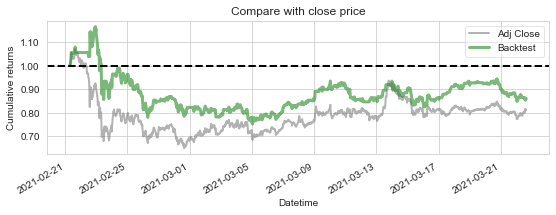

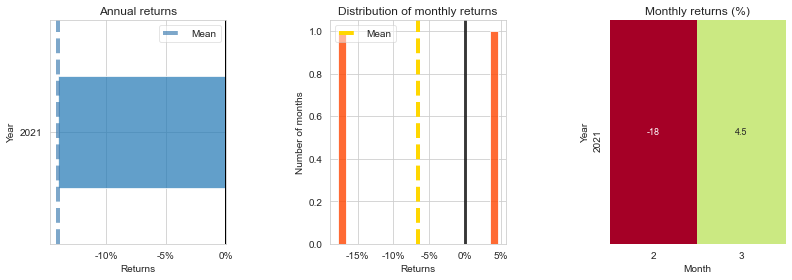

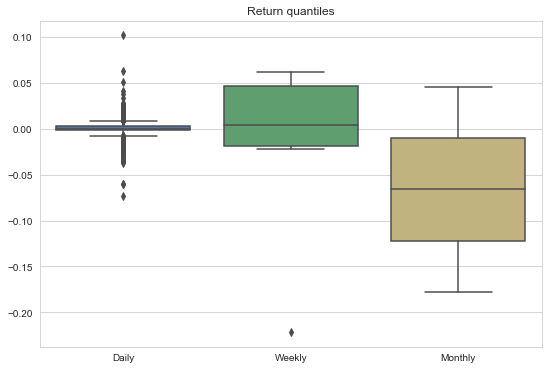

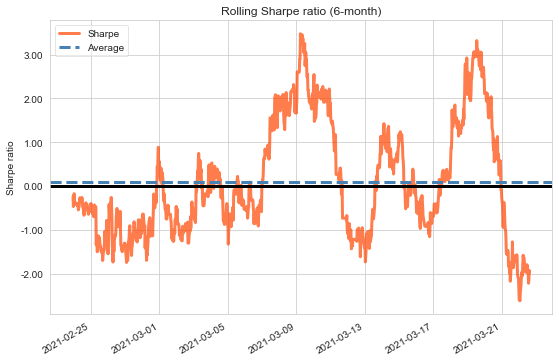

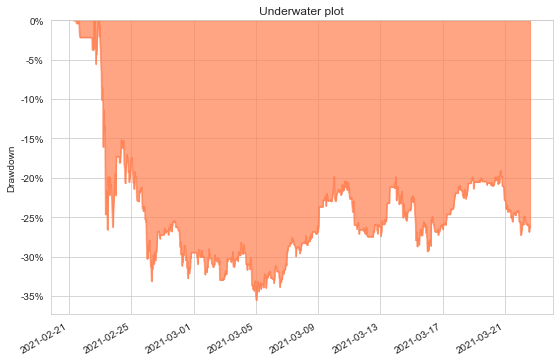

In [8]:
bt_returns = result['portfolio_value'].pct_change()
# bm_returns = bn['Benchmark'].pct_change()
price = test_data['Adj Close'].pct_change()

# plt.figure(figsize=(9,6));
# plt.subplot(2,1,1);
# pf.plotting.plot_rolling_returns(bt_returns, bm_returns);
# plt.title('Compare with Benchmark');
# plt.show()

plt.figure(figsize=(9,6));
plt.subplot(2,1,1);
pf.plotting.plot_rolling_returns(bt_returns, price);
plt.title('Compare with close price');
plt.show()

fig = plt.figure(1)
plt.subplot(1,3,1)
pf.plot_annual_returns(bt_returns)
plt.subplot(1,3,2)
pf.plot_monthly_returns_dist(bt_returns)
plt.subplot(1,3,3)
pf.plot_monthly_returns_heatmap(bt_returns)
plt.tight_layout()
fig.set_size_inches(12,4)

plt.figure(figsize=(9,6))
pf.plot_return_quantiles(bt_returns);



plt.figure(figsize=(9,6))
pf.plot_rolling_sharpe(bt_returns);

plt.figure(figsize=(9,6))
pf.plot_drawdown_underwater(bt_returns);

In [9]:
result.index.name = 'Date'
result.to_csv(f'../data/{stock_name}.csv')